# The Optimal use of Silicon Pixel Charge Information for Particle Identification

Authors: Harley Patton, Benjamin Nachman

In [1]:
# download dependencies
import numpy as np
import scipy.io as sio
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
%matplotlib inline

Let's begin with a simulated sample of the energy loss ($dE/dx$) of pion and kaon tracks through 4 layers (200 $\mu$m thick, pitch of $50\times250$ $\mu\text{m}^2$) of a detector similar in setup to the ATLAS pixel detector. The tracks are simulated using Allpix, built on the Geant4 package, and have a momentum of 400 MeV and are perpendicular to the detector $(\eta = 0)$.

In [2]:
# load the simulated data
eta0_p400MeV_pk = sio.loadmat("mat/eta0_p400MeV_pion_kaon")

# extract the data matrices
energy_loss = eta0_p400MeV_pk["X"]
particle_ID = eta0_p400MeV_pk["y"][0] # binary: 0 = pion, 1 = kaon

pion_tracks = energy_loss[particle_ID == 0]
kaon_tracks = energy_loss[particle_ID == 1]

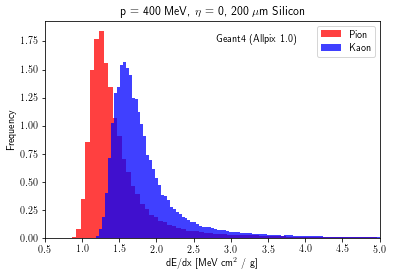

In [3]:
# plot the distributions of dE/dx for pion vs kaon tracks
plt.hist(np.mean(pion_tracks, axis=1), 350, normed=1,
         facecolor='r', alpha=0.75, label="Pion")
plt.hist(np.mean(kaon_tracks, axis=1), 350, normed=1,
         facecolor='b', alpha=0.75, label="Kaon")
plt.xlim([0.5, 5])
plt.ylabel('Frequency')
plt.xlabel('dE/dx [MeV cm$^2$ / g]')
plt.legend(loc='upper right')
plt.title("p = 400 MeV, $\eta$ = 0, 200 $\mu$m Silicon")
plt.text(2.8,1.75,"Geant4 (Allpix 1.0)")

The energy loss distributions for pion and kaon tracks are roughly Landau-distributed, with heavy tails that carry little to no discriminatory power. For this reason, truncation (in which the higher valued element(s) of a sample point are thrown out)is a common approach to $dE/dx$ based classification. A particulary common heuristic is the truncated mean, defined for a sample point $\vec{x} \in \mathbb{R}^n$ as:

$$\mu_t(x) = \frac{1}{|A|}\sum_{i \in A}x_i,\;\;\;A =
\{i : x_i \neq \max x\}$$

We introduce a similar feature, the thresholded mean, which removes all elements of the sample point $x$ that surpass a hyperparameter $\theta$:

$$\mu_\theta(x) = \frac{1}{|B|}\sum_{i \in B}x_i,\;\;\;B =
\{i : x_i < \theta\}$$

We can observe the classification power of these heuristics in comparison to the unmodified mean.

In [4]:
# calculate the mean of each sample point
def means(data_mat):
    return np.mean(data_mat, axis=1).reshape(-1, 1)

# calculate the truncated mean of each sample point
def truncated_means(data_mat):
    trunc_means = []
    for sample_point in data_mat:
        truncated = sample_point[sample_point < max(sample_point)]
        trunc_means.append(np.mean(truncated))
    return np.array(trunc_means).reshape(-1, 1)

# calculate the thresholded mean of each sample point
def thresholded_means(data_mat, theta):
    thres_means = []
    for sample_point in data_mat:
        thresholded = sample_point[sample_point < theta]
        if len(thresholded) == 0:
            thres_means.append(0)
        else:
            thres_means.append(np.mean(thresholded))
    return np.array(thres_means).reshape(-1, 1)

In [5]:
# partition the energy_loss dataset into training and testing sets
# X_test, X_train <- dE/dx data matrices
# y_test, y_train <- particleID vectors

# load the testing data
X_test = eta0_p400MeV_pk["X_test"]
y_test = eta0_p400MeV_pk["y_test"][0]

# load the training data
X_train = eta0_p400MeV_pk["X_train"]
y_train = eta0_p400MeV_pk["y_train"][0]

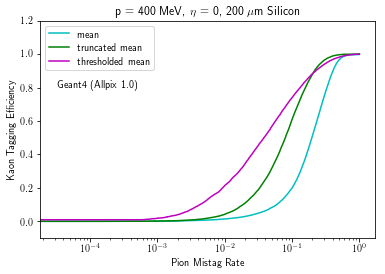

In [6]:
# train classifier on means
mean_NB = GaussianNB()
mean_NB.fit(means(X_train), y_train)

# train classifier on truncated means
trunc_NB = GaussianNB()
trunc_NB.fit(truncated_means(X_train), y_train)

# train classifier on thresholded means with theta=1.8
theta = 1.8
thres_NB = GaussianNB()
thres_NB.fit(thresholded_means(X_train, theta), y_train)

# plot ROC curve
plt.title("p = 400 MeV, $\eta$ = 0, 200 $\mu$m Silicon")

fpr_1, tpr_1, _ = roc_curve(
    y_test, mean_NB.predict_proba(means(X_test))[:,1])
plt.plot(fpr_1, tpr_1, 'c')

fpr_2, tpr_2, _ = roc_curve(
    y_test, trunc_NB.predict_proba(truncated_means(X_test))[:,1])
plt.plot(fpr_2, tpr_2, 'g')

fpr_3, tpr_3, _ = roc_curve(
    y_test, thres_NB.predict_proba(thresholded_means(X_test, theta))[:,1])
plt.plot(fpr_3, tpr_3, 'm')

plt.ylim([-0.1,1.2])
plt.ylabel('Kaon Tagging Efficiency')
plt.xlabel('Pion Mistag Rate')
plt.text(10**(-4.5), 0.8,"Geant4 (Allpix 1.0)")
plt.xscale("log")
plt.legend(("mean", "truncated mean", "thresholded mean"))

The above ROC curve shows that truncation greatly improves the classification power of $dE/dx$, and that the optimal threshold at which to truncate can be learned from data. Classification power can be increased further by introducing a measure of spread. We introduce the truncated standard deviation:

$$\sigma_t(x) = \sqrt {\frac{1}{|A|}\sum_{i \in A}(x_i - \mu_t(x))^2},\;\;\;A =
\{i : x_i \neq \max x\}$$

We also introduce the following feature map $\Phi: \mathbb{R}^n \rightarrow \mathbb{R}^2$:

$$\Phi(x) = (\mu_t(x), \sigma_t(x))$$

We will show that this reduced feature space contains all of the classification power as the original $n$-dimensional space.

In [7]:
# calculate the truncated stddev of each sample point
def truncated_stddevs(data_mat):
    trunc_stddevs = []
    for sample_point in data_mat:
        truncated = sample_point[sample_point < max(sample_point)]
        trunc_stddevs.append(np.std(truncated))
    return np.array(trunc_stddevs).reshape(-1, 1)

# map a data matrix to the reduced feature space
def reduced_features(data_mat):
    trunc_means = truncated_means(data_mat)
    trunc_stddevs = truncated_stddevs(data_mat)
    return np.hstack((trunc_means, trunc_stddevs))

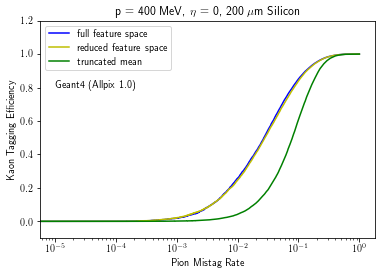

In [8]:
# train classifier on full feature space
full_NN = MLPClassifier()
full_NN.fit(X_train, y_train)

# train classifier on reduced feature space
reduced_NN = MLPClassifier()
reduced_NN.fit(reduced_features(X_train), y_train)

# plot ROC curve
plt.title("p = 400 MeV, $\eta$ = 0, 200 $\mu$m Silicon")

fpr_1, tpr_1, _ = roc_curve(
    y_test, full_NN.predict_proba(X_test)[:,1])
plt.plot(fpr_1, tpr_1, 'b')

fpr_2, tpr_2, _ = roc_curve(
    y_test, reduced_NN.predict_proba(reduced_features(X_test))[:,1])
plt.plot(fpr_2, tpr_2, 'y')

fpr_3, tpr_3, _ = roc_curve(
    y_test, trunc_NB.predict_proba(truncated_means(X_test))[:,1])
plt.plot(fpr_3, tpr_3, 'g')

plt.ylim([-0.1,1.2])
plt.ylabel('Kaon Tagging Efficiency')
plt.xlabel('Pion Mistag Rate')
plt.text(1e-5, 0.8,"Geant4 (Allpix 1.0)")
plt.xscale("log")
plt.legend(("full feature space", "reduced feature space", "truncated mean"))

As the above ROC curve shows, an artificial neural network trained on only the reduced feature space performs identically to one trained on the full $n$-dimensional space. The performance of the truncated mean classifier is also included for comparison.

The ramifications of this are two-fold: first, we have shown that truncation is a lossless operation; second, we have shown that the full information of the $dE/dx$ distribution can be compressed to 2 dimensions.

Although this reduced space is small in dimensionality, it could still produce a decision boundary that is arbitrarily complicated. We will now show that this reduced feature space can be further compressed to a single feature, and that the optimal classifier on this single feature will produce linear decision boundary. To be more precise, we will show that the optimal classifier can be approximated by determining on which side of a cut on $u_t - \sigma_t^2$ a sample point lies.

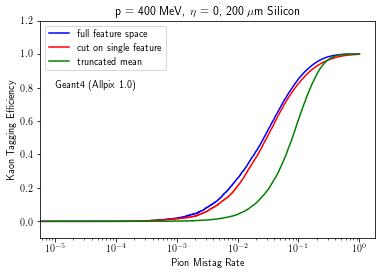

In [9]:
# single feature data (mu - sigma^2)
singlefeat_train = truncated_means(X_train) - truncated_stddevs(X_train)**2
singlefeat_test = truncated_means(X_test) - truncated_stddevs(X_test)**2

# train a linear classifier on single feature
singlefeat_SVM = SVC(kernel="linear", probability=True)
singlefeat_SVM.fit(singlefeat_train, y_train)

# plot ROC curve
plt.title("p = 400 MeV, $\eta$ = 0, 200 $\mu$m Silicon")

fpr_1, tpr_1, _ = roc_curve(
    y_test, full_NN.predict_proba(X_test)[:,1])
plt.plot(fpr_1, tpr_1, 'b')

fpr_2, tpr_2, _ = roc_curve(
    y_test, singlefeat_SVM.predict_proba(singlefeat_test)[:,1])
plt.plot(fpr_2, tpr_2, 'r')

fpr_3, tpr_3, _ = roc_curve(
    y_test, trunc_NB.predict_proba(truncated_means(X_test))[:,1])
plt.plot(fpr_3, tpr_3, 'g')


plt.ylim([-0.1,1.2])
plt.ylabel('Kaon Tagging Efficiency')
plt.xlabel('Pion Mistag Rate')
plt.text(1e-5, 0.8,"Geant4 (Allpix 1.0)")
plt.xscale("log")
plt.legend(("full feature space", "cut on single feature", "truncated mean"))

As the above ROC curve shows, a linear cut on our single feature performs identically to a neural network trained on the full sample points. We have arrived at a feature with the classification power of the full energy loss distribution, while maintaining the simplicity of the truncated mean.

We observe similar results at varying momenta. Below is the same analysis, with tracks at a momentum of 600 MeV. All other factors remain the same.

In [10]:
# load the simulated data
eta0_p600MeV_pk = sio.loadmat("mat/eta0_p600MeV_pion_kaon")

# load the testing data
X_test = eta0_p600MeV_pk["X_test"]
y_test = eta0_p600MeV_pk["y_test"][0]

# load the training data
X_train = eta0_p600MeV_pk["X_train"]
y_train = eta0_p600MeV_pk["y_train"][0]

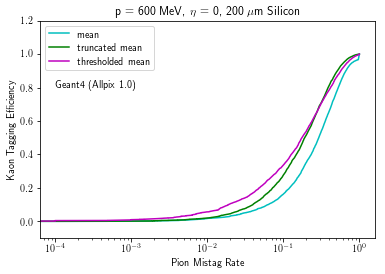

In [11]:
# train classifier on means
mean_NB = GaussianNB()
mean_NB.fit(means(X_train), y_train)

# train classifier on truncated means
trunc_NB = GaussianNB()
trunc_NB.fit(truncated_means(X_train), y_train)

# train classifier on thresholded means with theta=1.8
theta = 1.8
thres_NB = GaussianNB()
thres_NB.fit(thresholded_means(X_train, theta), y_train)

# plot ROC curve
plt.title("p = 600 MeV, $\eta$ = 0, 200 $\mu$m Silicon")

fpr_1, tpr_1, _ = roc_curve(
    y_test, mean_NB.predict_proba(means(X_test))[:,1])
plt.plot(fpr_1, tpr_1, 'c')

fpr_2, tpr_2, _ = roc_curve(
    y_test, trunc_NB.predict_proba(truncated_means(X_test))[:,1])
plt.plot(fpr_2, tpr_2, 'g')

fpr_3, tpr_3, _ = roc_curve(
    y_test, thres_NB.predict_proba(thresholded_means(X_test, theta))[:,1])
plt.plot(fpr_3, tpr_3, 'm')

plt.ylim([-0.1,1.2])
plt.ylabel('Kaon Tagging Efficiency')
plt.xlabel('Pion Mistag Rate')
plt.text(1e-4, 0.8,"Geant4 (Allpix 1.0)")
plt.xscale("log")
plt.legend(("mean", "truncated mean", "thresholded mean"))

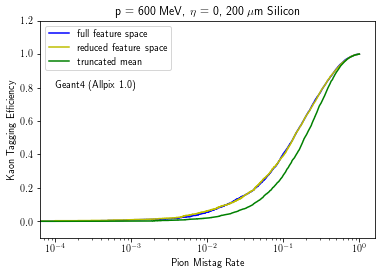

In [12]:
# train classifier on full feature space
full_NN = MLPClassifier()
full_NN.fit(X_train, y_train)

# train classifier on reduced feature space
reduced_NN = MLPClassifier()
reduced_NN.fit(reduced_features(X_train), y_train)

# plot ROC curve
plt.title("p = 600 MeV, $\eta$ = 0, 200 $\mu$m Silicon")

fpr_1, tpr_1, _ = roc_curve(
    y_test, full_NN.predict_proba(X_test)[:,1])
plt.plot(fpr_1, tpr_1, 'b')

fpr_2, tpr_2, _ = roc_curve(
    y_test, reduced_NN.predict_proba(reduced_features(X_test))[:,1])
plt.plot(fpr_2, tpr_2, 'y')

fpr_3, tpr_3, _ = roc_curve(
    y_test, trunc_NB.predict_proba(truncated_means(X_test))[:,1])
plt.plot(fpr_3, tpr_3, 'g')


plt.ylim([-0.1,1.2])
plt.ylabel('Kaon Tagging Efficiency')
plt.xlabel('Pion Mistag Rate')
plt.text(1e-4, 0.8,"Geant4 (Allpix 1.0)")
plt.xscale("log")
plt.legend(("full feature space", "reduced feature space", "truncated mean"))

We also observe the same results with different particle types. Below is the same analysis, for the task of pion/proton classification at 400 MeV.

In [13]:
eta0_p400MeV_pp = sio.loadmat("mat/eta0_p400MeV_pion_proton.mat")

# load the testing data
X_test = eta0_p400MeV_pp["X_test"]
y_test = eta0_p400MeV_pp["y_test"][0]

# load the training data
X_train = eta0_p400MeV_pp["X_train"]
y_train = eta0_p400MeV_pp["y_train"][0]

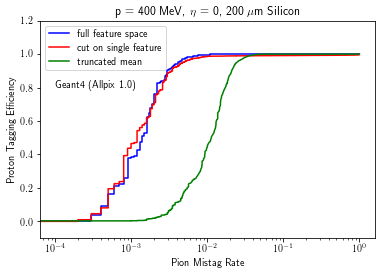

In [14]:
# train classifier on full feature space
full_NN = MLPClassifier()
full_NN.fit(X_train, y_train)

# train classifier on truncated means
trunc_NB = GaussianNB()
trunc_NB.fit(truncated_means(X_train), y_train)

singlefeat_train = truncated_means(X_train) - truncated_stddevs(X_train)**2
singlefeat_test = truncated_means(X_test) - truncated_stddevs(X_test)**2

# train linear classifier on single feature
singlefeat_SVM = SVC(kernel="linear", probability=True)
singlefeat_SVM.fit(singlefeat_train, y_train)

# plot ROC curve
plt.title("p = 400 MeV, $\eta$ = 0, 200 $\mu$m Silicon")

fpr_1, tpr_1, _ = roc_curve(
    y_test, full_NN.predict_proba(X_test)[:,1])
plt.plot(fpr_1, tpr_1, 'b')

fpr_2, tpr_2, _ = roc_curve(
    y_test, singlefeat_SVM.predict_proba(singlefeat_test)[:,1])
plt.plot(fpr_2, tpr_2, 'r')

fpr_3, tpr_3, _ = roc_curve(
    y_test, trunc_NB.predict_proba(truncated_means(X_test))[:,1])
plt.plot(fpr_3, tpr_3, 'g')


plt.ylim([-0.1,1.2])
plt.ylabel('Proton Tagging Efficiency')
plt.xlabel('Pion Mistag Rate')
plt.text(1e-4, 0.8,"Geant4 (Allpix 1.0)")
plt.xscale("log")
plt.legend(("full feature space", "cut on single feature", "truncated mean"))

And for kaon/proton classification at 400 MeV.

In [15]:
eta0_p400MeV_kp = sio.loadmat("mat/eta0_p400MeV_kaon_proton.mat")

# load the testing data
X_test = eta0_p400MeV_kp["X_test"]
y_test = eta0_p400MeV_kp["y_test"][0]

# load the training data
X_train = eta0_p400MeV_kp["X_train"]
y_train = eta0_p400MeV_kp["y_train"][0]

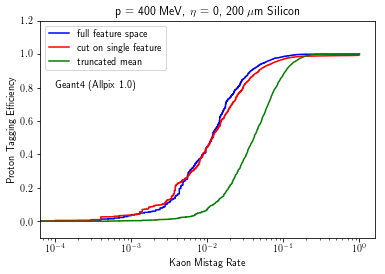

In [16]:
# train classifier on full feature space
full_NN = MLPClassifier()
full_NN.fit(X_train, y_train)

# train classifier on truncated means
trunc_NB = GaussianNB()
trunc_NB.fit(truncated_means(X_train), y_train)

singlefeat_train = truncated_means(X_train) - truncated_stddevs(X_train)**2
singlefeat_test = truncated_means(X_test) - truncated_stddevs(X_test)**2

# train linear classifier on single feature
singlefeat_SVM = SVC(kernel="linear", probability=True)
singlefeat_SVM.fit(singlefeat_train, y_train)

# plot ROC curve
plt.title("p = 400 MeV, $\eta$ = 0, 200 $\mu$m Silicon")

fpr_1, tpr_1, _ = roc_curve(
    y_test, full_NN.predict_proba(X_test)[:,1])
plt.plot(fpr_1, tpr_1, 'b')

fpr_2, tpr_2, _ = roc_curve(
    y_test, singlefeat_SVM.predict_proba(singlefeat_test)[:,1])
plt.plot(fpr_2, tpr_2, 'r')

fpr_3, tpr_3, _ = roc_curve(
    y_test, trunc_NB.predict_proba(truncated_means(X_test))[:,1])
plt.plot(fpr_3, tpr_3, 'g')


plt.ylim([-0.1,1.2])
plt.ylabel('Proton Tagging Efficiency')
plt.xlabel('Kaon Mistag Rate')
plt.text(1e-4, 0.8,"Geant4 (Allpix 1.0)")
plt.xscale("log")
plt.legend(("full feature space", "cut on single feature", "truncated mean"))